In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_evol
from scipy.special import jv

In [2]:
def ind(m, N, a):
    return f"{m=:0.4f}_{N=:d}_{a=:0.3f}"

In [3]:
g = 1 / 5
v, Q = 1, 1
D0, D, tol = 64, 64, 1e-6
#
ms = [0 * g, 0.1 * g, 0.318309886 * g, 1 * g]
Nas =  [(256, 0.5), (512, 0.25)]

data = {}

for m in ms:
    for N, a in Nas:
        dt = 1/8
        folder = folder_evol(g, m, a, N, v, Q, D0, dt, D, tol)
        data[ind(m, N, a)] = np.load(folder / f"results.npy", allow_pickle=True).item()

Total energy in time

In [4]:
# test energy from MPO vs T00
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):
        k = ind(m, N, a)
        mask = data[k]["time"] > -1  # when some points not calculated yet
        x1 = np.sum(data[k]["T00"][mask, :], axis=1) * a
        x2 = data[k]["energy"][mask]
        assert np.max(np.abs((np.abs(1 - x1 / x2) ))) < 1e-10

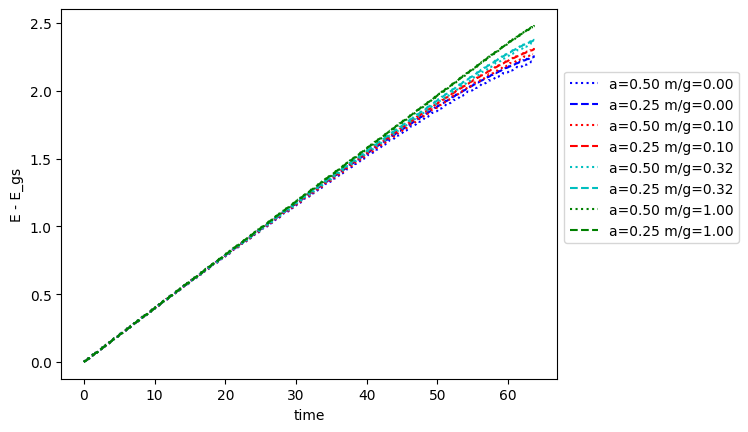

In [5]:
clrs = dict(zip(ms, 'brcg'))
smbs = {256: ':', 512: '--', 1024: '-'}

for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):
        k = ind(m, N, a)
        tm = data[k]["time"]

        mask = tm > -1
        tm = tm[mask]
        en = data[k]["energy"][mask]

        plt.plot(tm[:-4], en[:-4] - en[0], smbs[N], color=clrs[m], label=f"{a=:0.2f} {m/g=:0.2f}")

plt.xlabel('time')
plt.ylabel('E - E_gs')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

von Neuman entropy between left and right parts of the lattice; Here, we subtract values in the initial state.  Note the crossover point at m/g = 1/pi

-0.13645629006902293 1.516509524273434


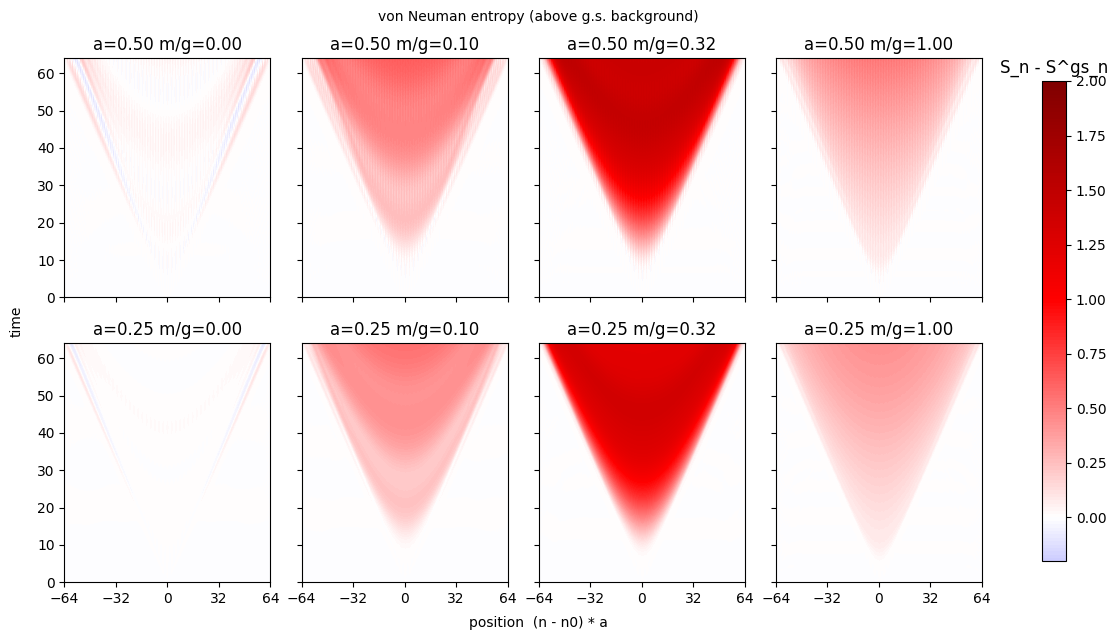

In [6]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6))

zmin, zmax = 0, 0
zlim = 2.0
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["entropy_1"][mask]
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N*a/2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])

print(zmin, zmax)

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('S_n - S^gs_n')
cb.ax.set_ylim([-0.2, zlim])

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'von Neuman entropy (above g.s. background)', ha='center');


Entropy (see above) at middle cut n=n0; without subtracting the value at t=0;  The convergence, in particular at late times will have to be checked;  Logarithmic (in a or N) contribution in the initial state is clearly visible.

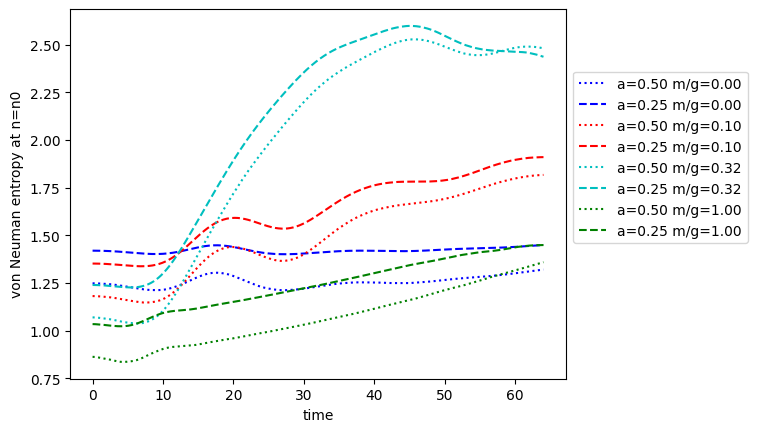

In [7]:
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):
        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["entropy_1"][mask]
        # ee = ee - ee[0]

        plt.plot(tm, ee[:, N // 2], smbs[N], color=clrs[m], label=f"{a=:0.2f} {m/g=:0.2f}")
plt.xlabel('time')
plt.ylabel('von Neuman entropy at n=n0')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

T00 - T00(t=0);  We might avarage over [2*l, 2*l+1] sites.


data range -0.01556240937226172 0.2806934105821792
analytical range 0.0 0.5373378639266894


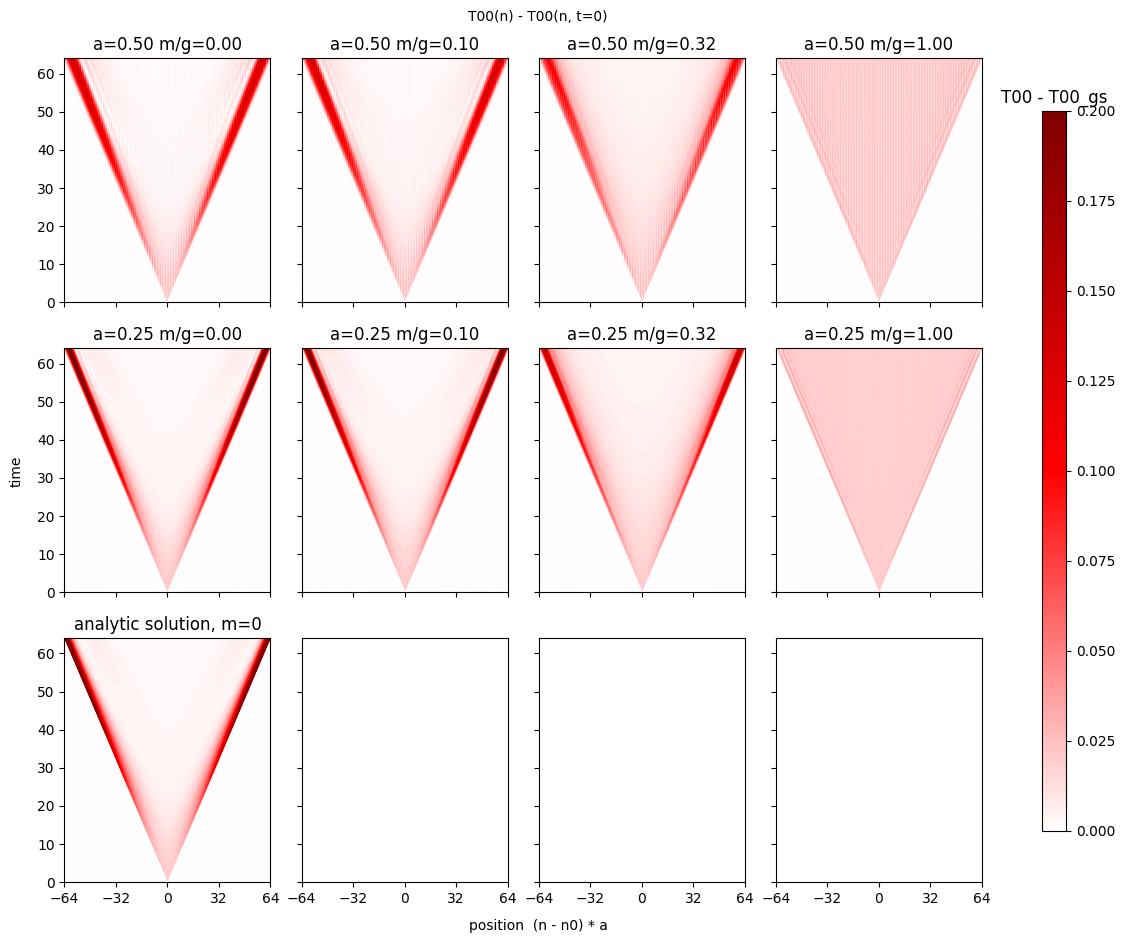

In [8]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmin, zmax = 0, 0
zlim = 0.2
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["T00"][mask]
        # ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # avarage over 2*n and 2*n+1
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])

N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aT00 = jv(0,  arg) ** 2 + (t**2 + x**2) * jv(1, arg)**2 / tl
aT00 *= (mb ** 2) * np.pi / 2
aT00[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(aT00, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aT00), np.max(aT00))


fig.tight_layout()
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('T00 - T00_gs')
cb.ax.set_ylim([0.0, zlim])

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'T00(n) - T00(n, t=0)', ha='center');

T11; We avarage over [2*l, 2*l+1] sites, and subtract initial value.

data range -0.05135193963675655 0.2796719269838066
analytical range -0.01999428458208071 0.4973537458490286


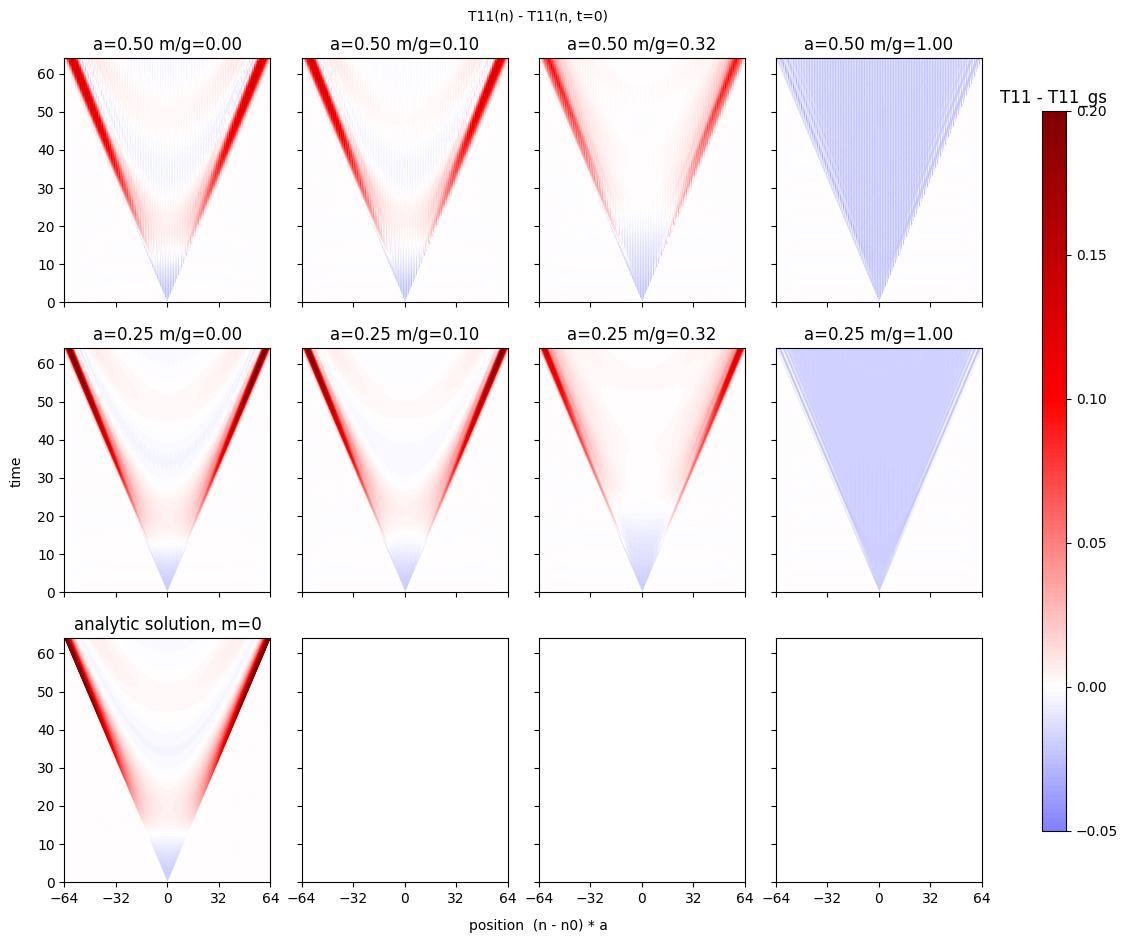

In [9]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmin, zmax = 0, 0
zlim = 0.2
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["T11"][mask]
        # ee = (ee[:, 0::2] + ee[:, 1::2]) / 2
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])

N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aT11 = -jv(0,  arg) ** 2 + (t**2 + x**2) * jv(1, arg)**2 / tl
aT11 *= (mb ** 2) * np.pi / 2
aT11[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(aT11, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aT11), np.max(aT11))

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('T11 - T11_gs')
cb.ax.set_ylim([-zlim/4, zlim])

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'T11(n) - T11(n, t=0)', ha='center');

T01 - T01(t=0); We can avarage over [2*l, 2*l+1] sites.

data range -0.44041584675754303 0.4404095601123734
analytical range -0.5173458048726244 0.5173458048726227


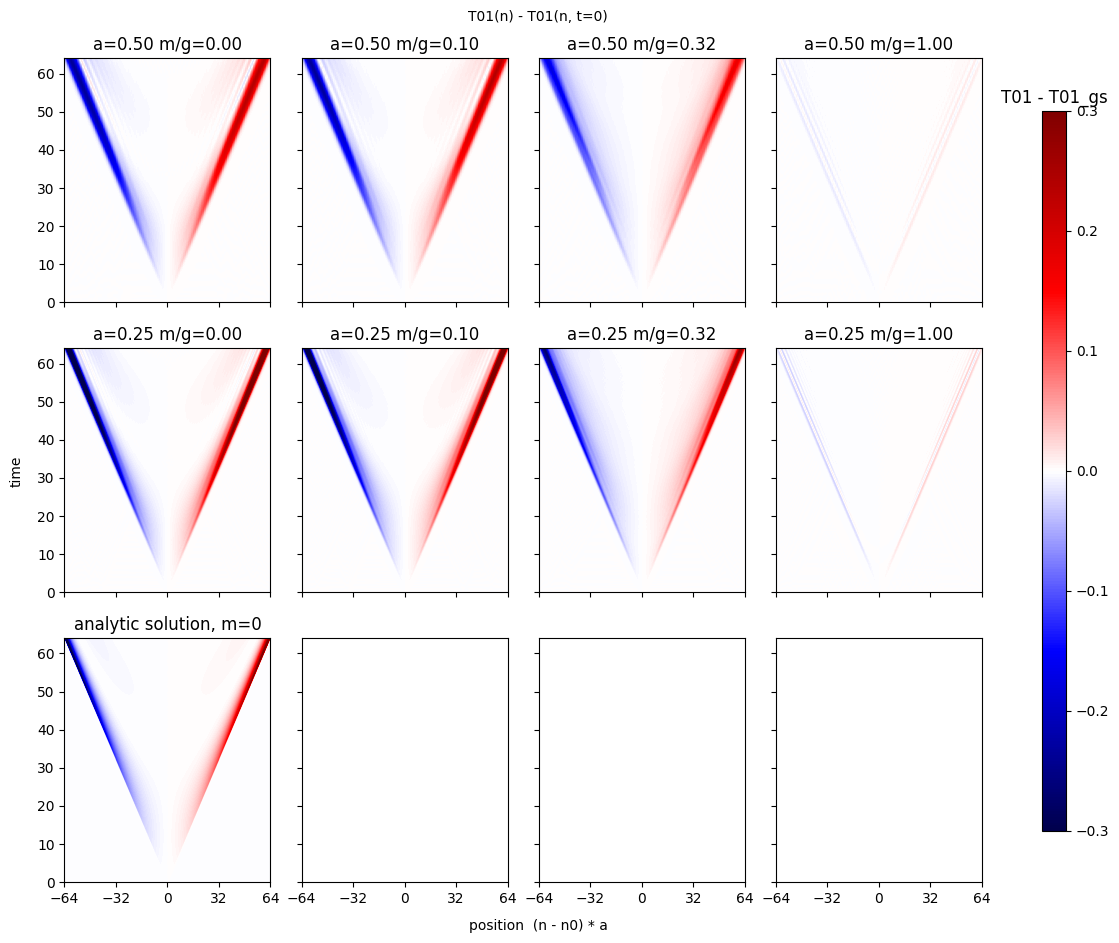

In [10]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmin, zmax = 0, 0
zlim = 0.3
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["T01"][mask]
        ee = (ee[:, 0::2] + ee[:, 1::2]) / 2
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])


N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aT01 = (t * x) * jv(1, arg)**2 / tl
aT01 *= (mb ** 2) * np.pi
aT01[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(aT01, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aT01), np.max(aT01))


fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('T01 - T01_gs')

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'T01(n) - T01(n, t=0)', ha='center');

j0; subtract j0(t=0)

data range -0.5630117259977458 0.5630150447030009
analytical range -0.40580170094644746 0.40580170094644813


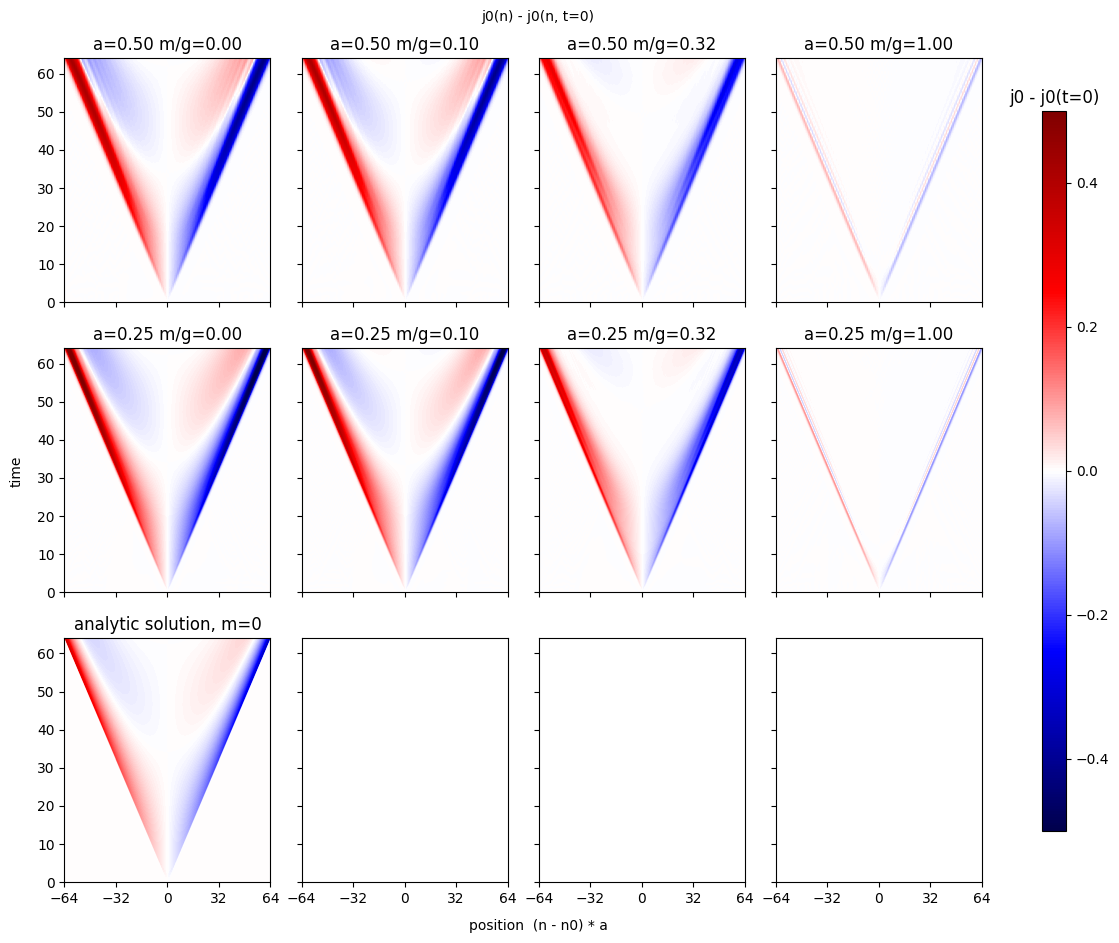

In [11]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmin, zmax = 0, 0
zlim = 0.5
for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["j0"][mask]
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])


N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aj0 = -mb * (x / np.sqrt(tl)) * jv(1, arg)
aj0[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(aj0, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aj0), np.max(aj0))


fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('j0 - j0(t=0)')

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'j0(n) - j0(n, t=0)', ha='center');

j1;

data range -0.521386264338926 0.1303417282860328
analytical range -0.40580481521539574 0.05389516701249945


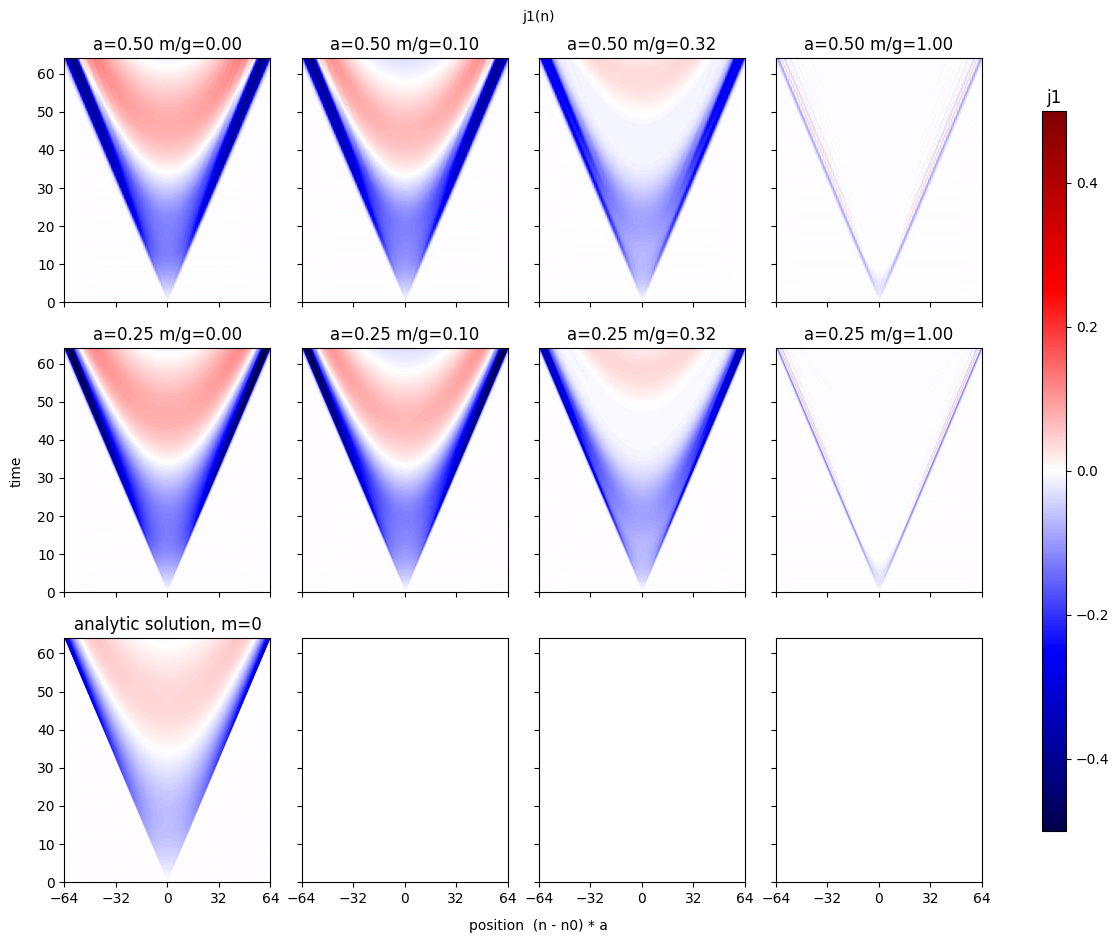

In [12]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmax, zmin = 0, 0
zlim = 0.5

for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["j1"][mask]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])


N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aj1 = - mb * (t / np.sqrt(tl)) * jv(1, arg)
aj1[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(aj1, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aj1), np.max(aj1))


fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('j1')

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'j1(n)', ha='center');

condensate

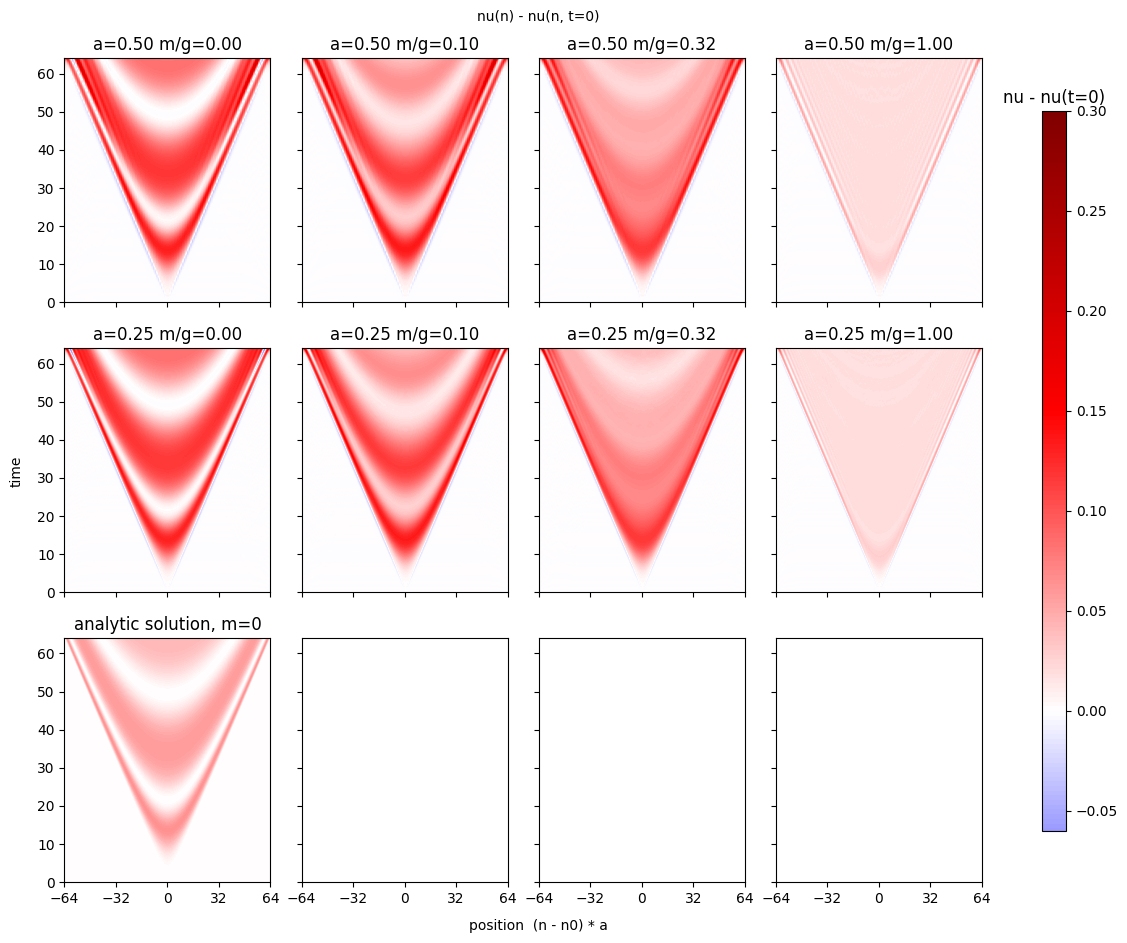

In [13]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmax, zmin = 0, 0
zlim = 0.3

for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["nu"][mask]
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])


N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

anu = 1 - np.cos(2 * np.pi * (1 - jv(0, arg)))
anu *= mb * np.exp(0.577215665) / (2 * np.pi)
anu[tl0 <= 0] = 0

j, i = 2, 0
ax[j, i].imshow(anu, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('nu - nu(t=0)')
cb.ax.set_ylim([-zlim / 5, zlim])

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'nu(n) - nu(n, t=0)', ha='center');

Ln

data range -0.9999637558399996 1.0463263747339226
analytical range -0.40275939562821794 0.9999751322423629


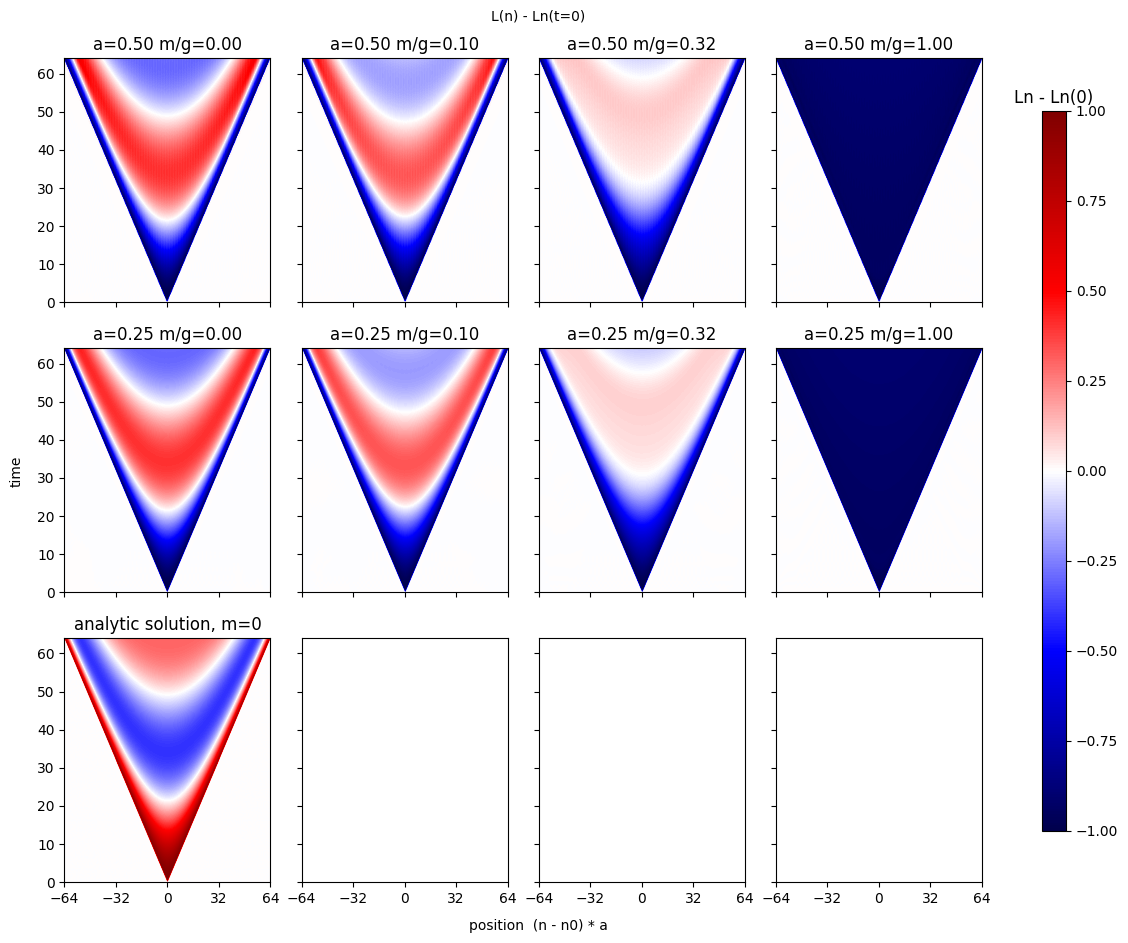

In [14]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 9))

zmax, zmin = 0, 0
zlim = 1.0

for i, m in enumerate(ms):
    for j, (N, a) in enumerate(Nas):

        k = ind(m, N, a)
        tm = data[k]["time"]
        mask = tm > -1
        tm = tm[mask]

        ee = data[k]["Ln"][mask]
        ee = ee - ee[0, :]

        zmax = max(zmax, np.max(ee))
        zmin = min(zmin, np.min(ee))

        xmax = N * a / 2
        im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
        ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f}")
        ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
        ax[j, i].set_ylim([0, xmax])


N = 512
mb = g / np.sqrt(np.pi)
x = np.linspace(-xmax, xmax, N).reshape(1, -1)
t = np.linspace(0, xmax, 2 * N + 1).reshape(-1, 1)
tl0 = t**2 - x**2
tl = tl0.copy()
tl[tl0 <= 0] = 1e-10
arg = mb * np.sqrt(tl)

aLn = jv(0, arg)
aLn[tl0 <= 0] = 0


j, i = 2, 0
ax[j, i].imshow(aLn, extent=(-xmax, xmax, 0, xmax),
                             origin='lower', aspect='auto',
                             vmin=-zlim, vmax=zlim,
                             cmap = cm.seismic)
ax[j, i].set_title(f"analytic solution, m=0")
ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
ax[j, i].set_ylim([0, xmax])

print("data range", zmin, zmax)
print("analytical range", np.min(aLn), np.max(aLn))


fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('Ln - Ln(0)')

fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
fig.text(0.43, 1.00, 'L(n) - Ln(t=0)', ha='center');
